# Algoritmo de Shor

Antes de empezar con el desarrollo del algoritmo de Shor, importaremos las librerías y funciones necesarias:

In [153]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from aux.qft import qft

Creamos una función que aplique f(x)=10^x mod 21 de periodo 6. 

In [158]:
def _10mod21():
    """
    Implementa la función f(x) = 10^x mod 21 para x de 0 a 31 (5 qubits de entrada, 5 de salida).
    Codifica a mano los primeros p=6 valores y repite el patrón periódicamente.
    """
    n = 5  # qubits de entrada
    m = 5  # qubits de salida
    p = 6  # periodo de la función
    valores = [1, 10, 16, 13, 4, 19]  # 10^x mod 21 para x=0..5

    circ = QuantumCircuit(n + m)

    # Inicializa el registro de salida en |1>
    circ.x(n + m - 1)  # qubit 9

    # Para cada x de 0 a 31
    for x in range(2**n):
        fx = valores[x % p]
        x_bits = [(x >> i) & 1 for i in range(n)]
        # Aplica compuertas de control para poner el registro de salida en fx
        for i in range(m):
            if ((fx >> i) & 1):
                controls = [j for j in range(n) if x_bits[j]]
                if controls:
                    circ.mcx(controls, n + i)
                else:
                    circ.x(n + i)

    # Transformar a puerta
    gate = circ.to_gate()
    gate.name = 'f(x) = 10^x mod 21'
    return gate

Con estas funciones ya podemos construir el circuito cuántico que representa el algoritmo de Shor para nuestro caso.

In [159]:
def shor():
    circ = QuantumCircuit(10, 5)
    circ.h(range(5))  # Hadamard en los primeros 5 qubits (registro de entrada)
    circ.append(_10mod21(), range(10))  # Aplica la función modular
    circ.measure(range(5, 10), range(5))  # Mide los 5 qubits de salida
    circ.barrier(range(10))
    circ.append(qft(5), range(5))  # QFT sobre los qubits de entrada
    circ.measure(range(5), range(5))  # Mide los qubits de entrada
    return circ

Mostramos el circuito

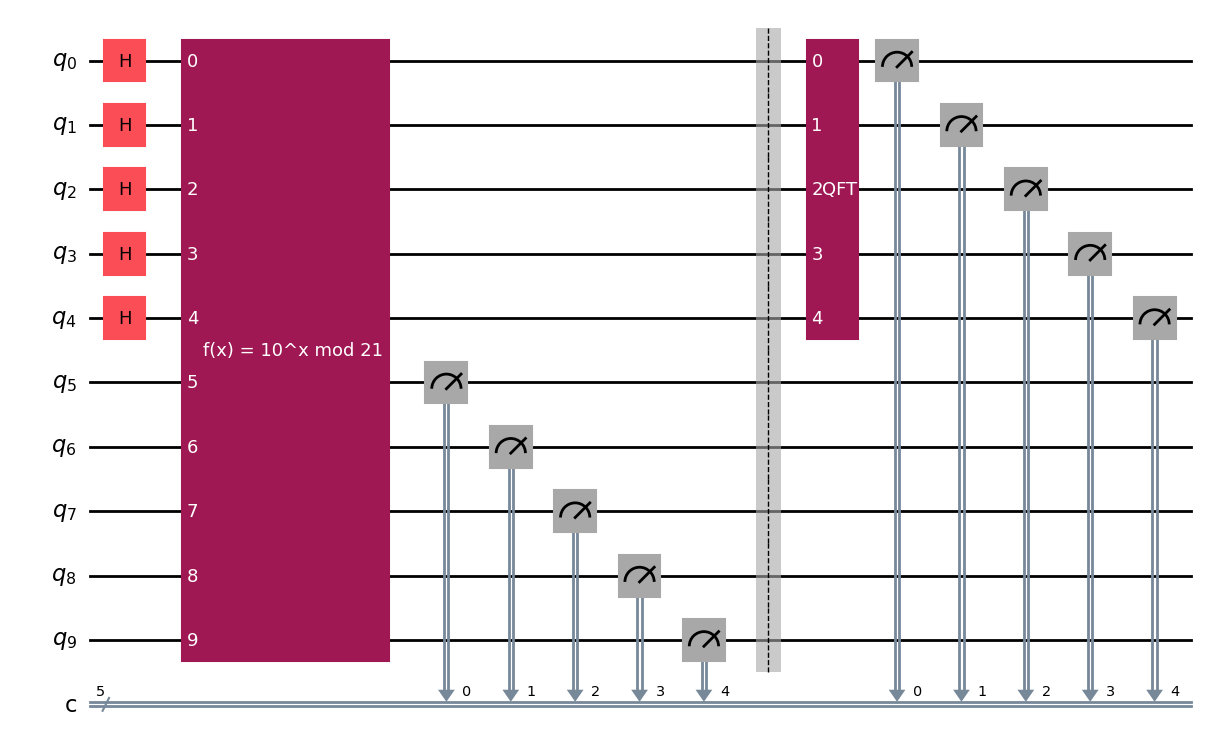

In [160]:
qc = shor()
qc.draw('mpl')

Realizamos las mediciones.

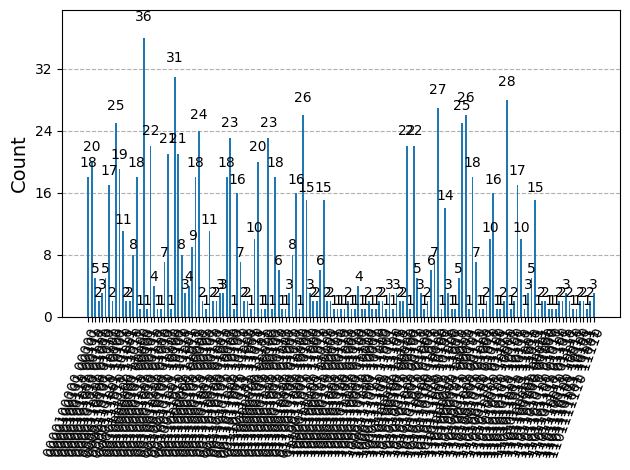

In [161]:
qc.measure_all()
backend = Aer.get_backend('qasm_simulator')
result = backend.run(transpile(qc, backend)).result()
counts = result.get_counts()
plot_histogram(counts)

Debido a que el diagrama no es muy claro ni fácil de interpretar, pasamos los números a decimal para mejorar la comprensión y nos centramos en los valores que aparecen con mayor frecuencia.


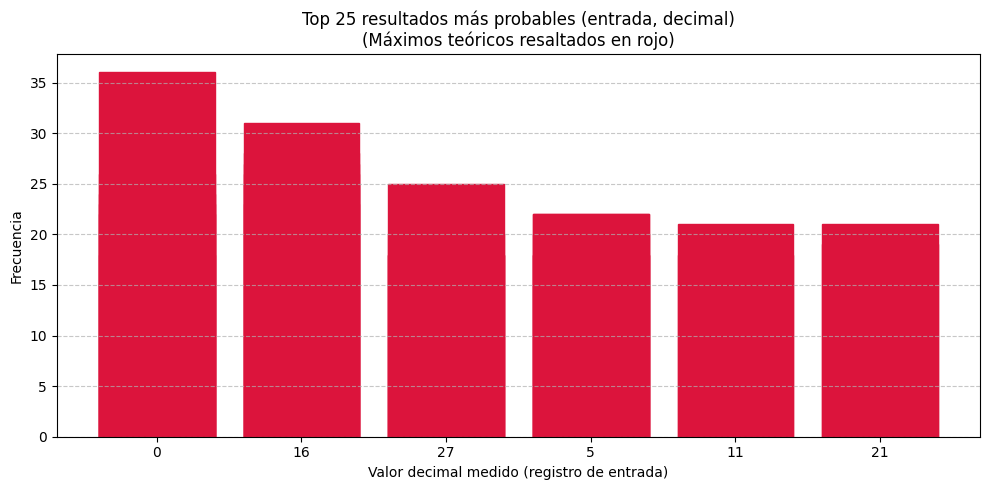

In [167]:
top_n = 25

# Ordenar los resultados por frecuencia
sorted_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)[:top_n]

# Extraer solo los primeros 5 bits (registro de entrada) de cada bitstring
bitstrings = [b.replace(" ", "") for b, _ in sorted_counts]
entrada_bits = [b[-5:] for b in bitstrings]  # últimos 5 bits (qubits 0-4)
decimals = [int(b, 2) for b in entrada_bits]
frequencies = [c for _, c in sorted_counts]

# Calcular los máximos teóricos esperados para n=5, p=6
n = 5
p = 6
maximos_esperados = [round(k * 2**n / p) for k in range(p)]

# Crear el gráfico de barras
plt.figure(figsize=(10, 5))
bars = plt.bar([str(d) for d in decimals], frequencies, color='mediumseagreen')

# Resalta los máximos teóricos en rojo
for i, d in enumerate(decimals):
    if d in maximos_esperados:
        bars[i].set_color('crimson')

plt.xlabel("Valor decimal medido (registro de entrada)")
plt.ylabel("Frecuencia")
plt.title(f"Top {top_n} resultados más probables (entrada, decimal)\n(Máximos teóricos resaltados en rojo)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Finalmente, con estos valores ya se pueden calcular los factores primos. Primero debemos encontrar el periodo de la funcion. Para ello se divide cada valor diferente de 0 y se calcula su fracción irreducible, el denominador de la fracción resultante será un candidato a periodo. Se dice candidato porque no todos cumplen la condicion de que x^p = 1 mod N. Por ello hay que comprobar si se cumple dicha condición. Si se tiene un periodo candidato que no cumple esta condicion, se prueba con sus múltiplos hasta encontrar uno que la cumpla, si es que existe. Finalmente, si el periodo es par se aplica el MCD y se calculan sus factores. En ocasiones, los factores que se encuentran son triviales por lo que se descartan.



In [ ]:
from fractions import Fraction
import math

N = 21
a = 10
n = 5


# Cogemos los valores maximos unicos de los resultados
valores_maximos_unicos = []
for d in decimals:
    if d in maximos_esperados and d != 0 and d not in valores_maximos_unicos:
        valores_maximos_unicos.append(d)


for s in valores_maximos_unicos:
    # De los valores medidos calculamos la fraccion irreducible s/2^n (s es el valor medido, y n el numero de qubits de entrada)cuyo denominador es un posible periodo
    frac = Fraction(s, 2**n).limit_denominator(N)
    r = frac.denominator
    print(f"\nValor medido: {s}")
    print(f"Fracción aproximada: {frac} (periodo candidato: {r})")
    # Busca el periodo real comprobando si a^(r*k) mod N = 1 para k=1,2,...,N-1
    periodo_encontrado = False
    for k in range(1, N):
        r_test = r * k
        if pow(a, r_test, N) == 1 and r_test != 0:
            print(f"Periodo real encontrado: {r_test}")
            # Si el periodo es par y cumple las condiciones, calcula los factores
            if r_test % 2 == 0:
                x = pow(a, r_test//2, N)
                factor1 = math.gcd(x - 1, N)
                factor2 = math.gcd(x + 1, N)
                print(f"Posibles factores primos: {factor1}, {factor2}")
                if factor1 not in [1, N] and factor2 not in [1, N]:
                    print("¡Factores encontrados!")
            else:
                print("El periodo no es par, prueba con otro máximo.")
            periodo_encontrado = True
            break
    if not periodo_encontrado:
        print("No se encontró un periodo válido para este máximo.")


Valor medido: 16
Fracción aproximada: 1/2 (periodo candidato: 2)
Periodo real encontrado: 6
Posibles factores primos: 3, 7
¡Factores encontrados!

Valor medido: 27
Fracción aproximada: 16/19 (periodo candidato: 19)
Periodo real encontrado: 114
Posibles factores primos: 3, 7
¡Factores encontrados!

Valor medido: 5
Fracción aproximada: 3/19 (periodo candidato: 19)
Periodo real encontrado: 114
Posibles factores primos: 3, 7
¡Factores encontrados!

Valor medido: 11
Fracción aproximada: 7/20 (periodo candidato: 20)
Periodo real encontrado: 60
Posibles factores primos: 21, 1

Valor medido: 21
Fracción aproximada: 13/20 (periodo candidato: 20)
Periodo real encontrado: 60
Posibles factores primos: 21, 1
